### Prerequisites


In [1]:
# data sources
dataset_prefix = (
    "s3://sagemaker-eu-central-1-092469060213/metadata/STraDa/datasets_balanced/"
)
embedding_prefix = "s3://sagemaker-eu-central-1-092469060213/data/STraDa/"

project_name = "gender_male"
encoder_id = "mert_v1_95m"

# data preparation
train_val_split = 0.9
target_column = "gender"
target_positive_class = "male"

# training
epochs = 200
batch_size = 128
learning_rate = 0.001
embedding_dim = 768
dropout_rate = 0.1


### Prepare Data


In [2]:
import io
import os
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import pandas as pd
import s3fs
from cavmir.training.dataset import TrainingSample, create_webdataset

s3 = s3fs.S3FileSystem(anon=False)


def create_embedding_path(song_id: str) -> str:
    return os.path.join(embedding_prefix, encoder_id, f"{song_id}.{encoder_id}.npy")


def create_training_sample(
    row: pd.Series, target_column: str, target_positive_class: str
) -> TrainingSample:
    embedding_path = create_embedding_path(row.song_id)
    embedding = np.load(io.BytesIO(s3.cat(embedding_path)))[0]

    target = np.array(
        [1] if getattr(row, target_column) == target_positive_class else [0]
    )

    training_sample = TrainingSample(
        id=str(row.song_id),
        embedding=embedding,
        target=target,
    )

    training_sample.validate_attributes()

    return training_sample


def create_training_samples(dataset: pd.DataFrame) -> list[TrainingSample]:
    with ThreadPoolExecutor() as executor:
        return list(
            executor.map(
                lambda row: create_training_sample(
                    row, target_column, target_positive_class
                ),
                dataset.itertuples(),
            )
        )

In [ ]:
df = pd.read_csv(os.path.join(dataset_prefix, f"train_dataset_{project_name}.csv"))
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

df_train = df.iloc[: int(len(df) * train_val_split)]
df_val = df.iloc[int(len(df) * train_val_split) :]

df_test = pd.read_csv(os.path.join(dataset_prefix, f"test_dataset_{project_name}.csv"))

In [ ]:
create_webdataset(
    create_training_samples(df_train),
    f"datasets/{encoder_id}_train_{project_name}.tar",
)

In [ ]:
create_webdataset(
    create_training_samples(df_val),
    f"datasets/{encoder_id}_val_{project_name}.tar",
)

In [ ]:
create_webdataset(
    create_training_samples(df_test),
    f"datasets/{encoder_id}_test_{project_name}.tar",
)

### Training


In [2]:
import os

import numpy as np
import torch
from cavmir.training.dataset import create_dataloader_from_webdataset_path
from cavmir.training.fit import fit_cav_model
from cavmir.training.network import SimpleDenseNetwork

In [3]:
train_dataloader = create_dataloader_from_webdataset_path(
    f"datasets/{encoder_id}_train_{project_name}.tar", batch_size=batch_size
)

val_dataloader = create_dataloader_from_webdataset_path(
    f"datasets/{encoder_id}_val_{project_name}.tar", batch_size=batch_size
)

model = SimpleDenseNetwork(
    input_shape=embedding_dim,
    target_shape=1,
    hidden_layers=[],
    dropout_rate=dropout_rate,
    nonlinear_last_layer=False,
)

/home/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/webdataset/compat.py:389: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn(


In [ ]:
fit_cav_model(
    model,
    train_dataloader,
    val_dataloader,
    f"trainings/{project_name}/",
    num_epochs=epochs,
    learning_rate=learning_rate,
)

Epoch 1/200
Epoch 1 Train Loss: 0.6510
Epoch 1 Validation Loss: 0.6160
Model saved to trainings/gender_male/state_dict.pth
Epoch 2/200
Epoch 2 Train Loss: 0.5854
Epoch 2 Validation Loss: 0.5658
Model saved to trainings/gender_male/state_dict.pth
Epoch 3/200
Epoch 3 Train Loss: 0.5430
Epoch 3 Validation Loss: 0.5300
Model saved to trainings/gender_male/state_dict.pth
Epoch 4/200
Epoch 4 Train Loss: 0.5162
Epoch 4 Validation Loss: 0.5048
Model saved to trainings/gender_male/state_dict.pth
Epoch 5/200
Epoch 5 Train Loss: 0.4929
Epoch 5 Validation Loss: 0.4857
Model saved to trainings/gender_male/state_dict.pth
Epoch 6/200
Epoch 6 Train Loss: 0.4764
Epoch 6 Validation Loss: 0.4693
Model saved to trainings/gender_male/state_dict.pth
Epoch 7/200
Epoch 7 Train Loss: 0.4654
Epoch 7 Validation Loss: 0.4570
Model saved to trainings/gender_male/state_dict.pth
Epoch 8/200
Epoch 8 Train Loss: 0.4527
Epoch 8 Validation Loss: 0.4462
Model saved to trainings/gender_male/state_dict.pth
Epoch 9/200
Epoc

In [4]:
model.load_state_dict(
    torch.load(
        os.path.join(
            "trainings",
            project_name,
            "state_dict.pth",
        )
    )
)

cav_vector = model.get_concept_activation_vector()


np.save(
    os.path.join(
        "trainings",
        project_name,
        f"cav_{project_name}.npy",
    ),
    cav_vector,
)

### Evaluation


In [5]:
import json

import matplotlib.pyplot as plt
from cavmir.training.evaluate import evaluate_cav_model


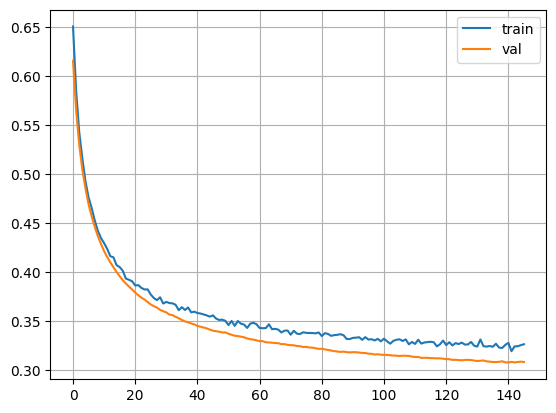

In [6]:
loss_history = json.load(open(f"trainings/{project_name}/loss_history.json"))

plt.plot(loss_history["train_loss"], label="train")
plt.plot(loss_history["val_loss"], label="val")
plt.legend()
plt.grid()
plt.show()


/home/arne/Documents/git/CAV-MIR/.venv/lib/python3.12/site-packages/webdataset/compat.py:389: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn(


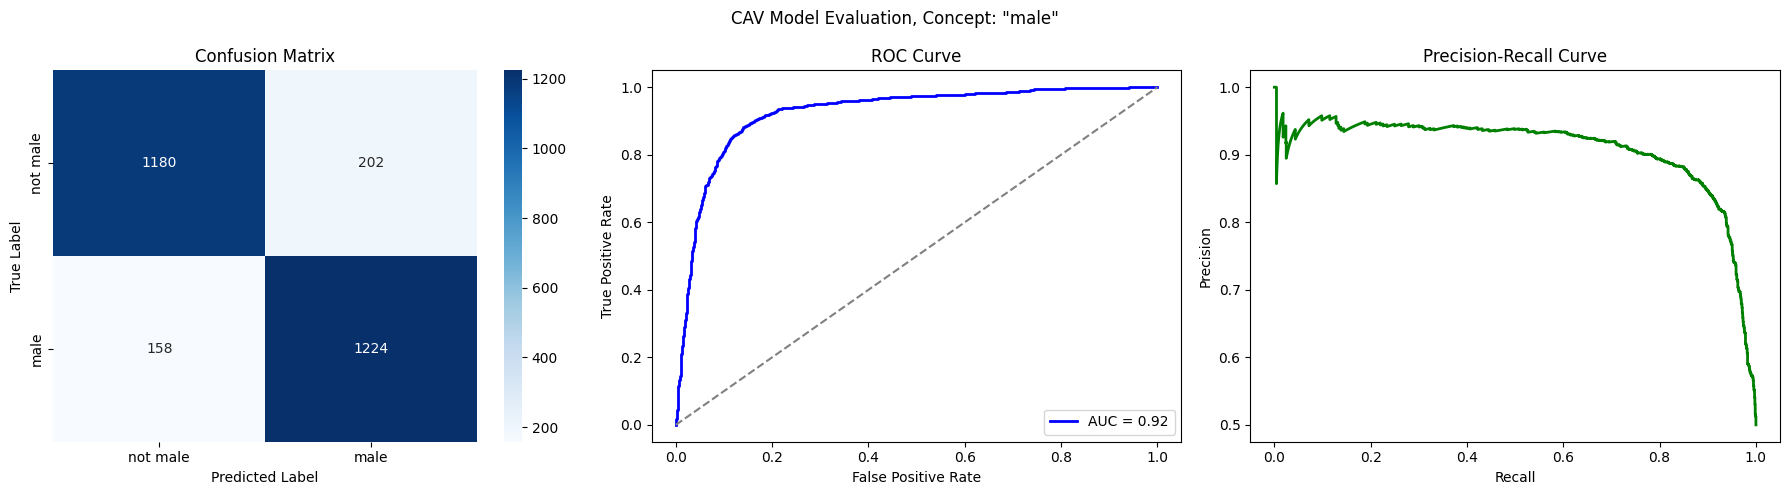

{'precision': 0.8583450210378681,
 'recall': 0.8856729377713459,
 'f1_score': 0.8717948717948718,
 'accuracy': 0.869753979739508}

In [7]:
test_dataloader = create_dataloader_from_webdataset_path(
    f"datasets/{encoder_id}_test_{project_name}.tar", batch_size=batch_size
)

evaluate_cav_model(model, test_dataloader, target_positive_class)
